In [2]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
#import qutip as qt
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

/Users/juan/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [293]:
fig_dir='/Users/juan/Google Drive/Brown/2017S/Machine Learning Applied to Scientific Data  - ENGN2912Z/NV-Tomography/';

In [3]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [5]:
prime_sample = learning.load_obj_2('diamonds/diamond_2')

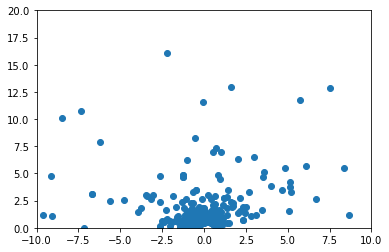

In [11]:
plt.figure()
plt.scatter(prime_sample['A']/analysis.mag,np.abs(prime_sample['B'])/analysis.mag)
plt.xlim(-10,10)
plt.ylim(0,20)
plt.show()

## Functionalize the fitting algorithm

In [232]:
def carbon_fit(diamond, guess_classifier, x_threshold):
    #guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
    #guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
    #Initialize results lists and others
    num_correct_list, num_incorrect_list = [], []
    As_list, Bs_list = [], []
    guess_As_list, guess_Bs_list = [], []
    dips_measured = []
    
    #print "diamond_ind: ", diamond_ind
    #diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    # replace spin_dict for a random guess
#     spin_dict = {}
#     for i in range(5000):
#         spin_dict[(np.random.randint(1,5000), 
#                    np.random.uniform(0.,np.pi), 
#                    np.random.uniform(0.,2.))] = [(np.random.uniform(-150*analysis.mag,150*analysis.mag),np.random.uniform(0.,150*analysis.mag),np.random.uniform(-0.99,0.99))]
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = x_threshold, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    A3 = np.copy(np.array(cluster_As));
    B3 = np.copy(np.array(cluster_Bs));
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    #As_list.append(As)
    #Bs_list.append(Bs)
    #guess_As_list.append(guess_As)
    #guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct
    # grab the stage-1 fit values
    A1=[]
    B1=[]
    for partial_set in spin_dictionary.itervalues():
        for member in partial_set:
            if len(member)>0:
                A1.append(member[0]);
                B1.append(member[1]);
    A1 = np.array(A1);
    B1 = np.array(B1);
    A2 = np.array(guess_As);
    B2 = np.array(guess_Bs);
    A4 = As;
    B4 = Bs;
    return [[[A1, B1], [A2, B2], [A3, B3], [A4, B4]], num_correct, len(As) - num_correct]

In [233]:
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
the_pipe = (lambda features: guess_clf.predict(guess_scaler.transform([features])))
#the_pipe = (lambda x: np.array([1.0]))

In [234]:
prime_sample = learning.load_obj_2('diamonds/diamond_3')

In [247]:
np.linspace(0.1,2.2,(2.2-0.1)/0.1+1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2])

In [236]:
for part in fit_sequence[0]:
    print('num fits = '+str(len(part[0])))

num fits = 2814
num fits = 23
num fits = 12
num fits = 11


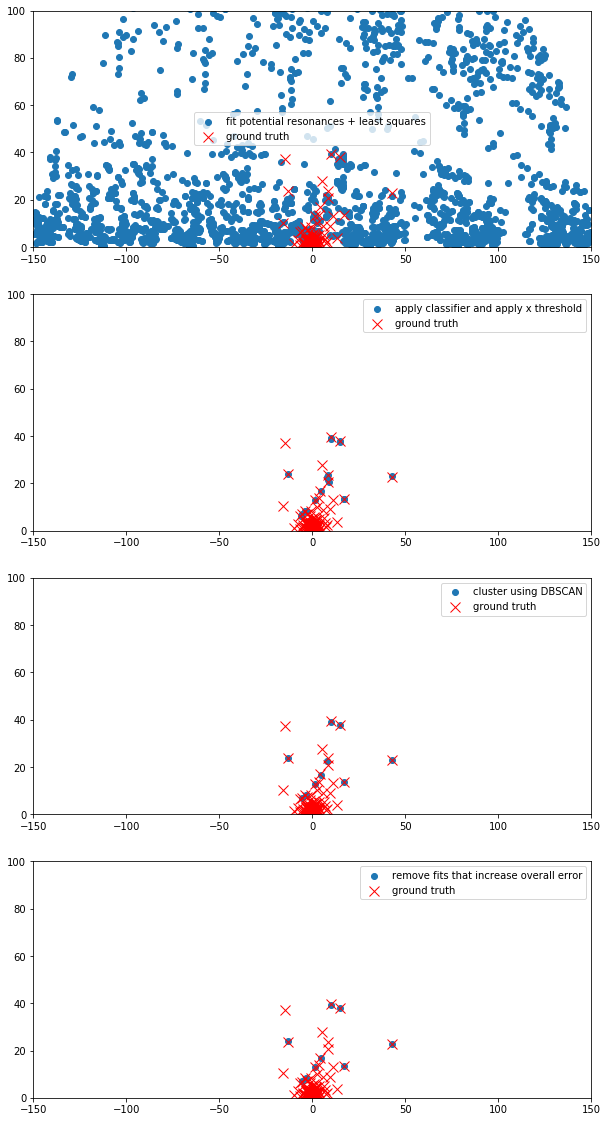

In [237]:
plt.figure(figsize=(10,20))
stage_names = ['fit potential resonances + least squares',
              'apply classifier and apply x threshold',
              'cluster using DBSCAN',
              'remove fits that increase overall error']
for stage, counter in zip(stage_names,range(len(fit_sequence[0]))):
    plt.subplot(len(fit_sequence[0]),1,counter+1)
    this_pair = fit_sequence[0][counter]
    plt.scatter(this_pair[0]/analysis.mag,this_pair[1]/analysis.mag,label=stage)
    plt.scatter(prime_sample['A']/analysis.mag,np.abs(prime_sample['B'])/analysis.mag, 
                s=100, lw=1, c='r',marker='x',
                label='ground truth')
    plt.xlim(-150,150)
    plt.ylim(0,100)
    plt.legend()
plt.show()

In [252]:
x_threshold_analysis = []
for x_t in np.linspace(0.1,1.9,(1.9-0.1)/0.1+1):
    print(x_t)
    fit_sequence = carbon_fit(prime_sample, the_pipe, x_t)
    x_threshold_analysis.append([x_t,fit_sequence[-2],fit_sequence[-1]])

0.1
dips measured:  382
num_removed:  4
correct:  15 incorrect:  5
0.205882352941
dips measured:  382
num_removed:  4
correct:  15 incorrect:  5
0.311764705882
dips measured:  382
num_removed:  3
correct:  15 incorrect:  5
0.417647058824
dips measured:  382
num_removed:  2
correct:  16 incorrect:  4
0.523529411765
dips measured:  382
num_removed:  1
correct:  16 incorrect:  5
0.629411764706
dips measured:  382
num_removed:  1
correct:  16 incorrect:  3
0.735294117647
dips measured:  382
num_removed:  1
correct:  17 incorrect:  1
0.841176470588
dips measured:  382
num_removed:  1
correct:  16 incorrect:  1
0.947058823529
dips measured:  382
num_removed:  1
correct:  15 incorrect:  1
1.05294117647
dips measured:  382
num_removed:  1
correct:  14 incorrect:  2
1.15882352941
dips measured:  382
num_removed:  0
correct:  12 incorrect:  1
1.26470588235
dips measured:  382
num_removed:  1
correct:  11 incorrect:  0
1.37058823529
dips measured:  382
num_removed:  1
correct:  11 incorrect:  0
1

In [253]:
x_threshold_analysis=np.array(x_threshold_analysis);

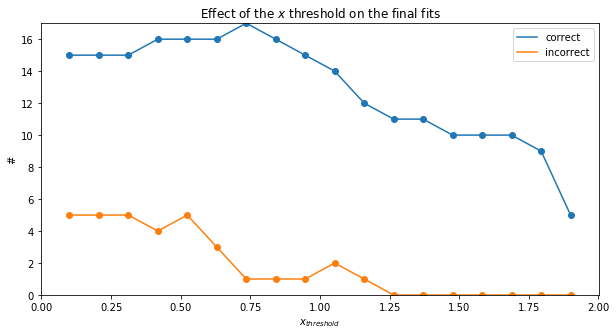

In [271]:
plt.figure(figsize=(10,5))
plt.scatter(x_threshold_analysis[:,0],x_threshold_analysis[:,1])
plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,1],label='correct')
plt.scatter(x_threshold_analysis[:,0],x_threshold_analysis[:,2])
plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,2],label='incorrect')
#plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,2]/x_threshold_analysis[:,1],label='incorrect')
plt.xlabel('$x_{threshold}$')
plt.ylabel('#')
plt.title('Effect of the $x$ threshold on the final fits')
plt.ylim(0,max(x_threshold_analysis[:,1]))
plt.legend()
plt.show()

In [275]:
# repeat the previous analysis but using an ensemble of samples
#all_threshold_analysis = []
for counter_1 in range(6,10):
    print(counter_1)
    prime_sample = learning.load_obj_2('diamonds/diamond_'+str(counter_1))
    x_threshold_analysis = []
    for x_t in np.linspace(0.1,1.9,(1.9-0.1)/0.1+1):
        print(x_t)
        fit_sequence = carbon_fit(prime_sample, the_pipe, x_t)
        x_threshold_analysis.append([x_t,fit_sequence[-2],fit_sequence[-1]])
    all_threshold_analysis.append(x_threshold_analysis)

6
0.1
dips measured:  420
num_removed:  6
correct:  14 incorrect:  8
0.205882352941
dips measured:  420
num_removed:  6
correct:  14 incorrect:  8
0.311764705882
dips measured:  420
num_removed:  4
correct:  14 incorrect:  8
0.417647058824
dips measured:  420
num_removed:  4
correct:  15 incorrect:  8
0.523529411765
dips measured:  420
num_removed:  3
correct:  14 incorrect:  8
0.629411764706
dips measured:  420
num_removed:  2
correct:  14 incorrect:  8
0.735294117647
dips measured:  420
num_removed:  2
correct:  14 incorrect:  7
0.841176470588
dips measured:  420
num_removed:  2
correct:  14 incorrect:  7
0.947058823529
dips measured:  420
num_removed:  2
correct:  13 incorrect:  6
1.05294117647
dips measured:  420
num_removed:  1
correct:  12 incorrect:  3
1.15882352941
dips measured:  420
num_removed:  1
correct:  10 incorrect:  1
1.26470588235
dips measured:  420
num_removed:  0
correct:  10 incorrect:  0
1.37058823529
dips measured:  420
num_removed:  0
correct:  10 incorrect:  0

In [276]:
import pickle

In [277]:
pickle.dump(all_threshold_analysis,open('threshold_analysis.pkl','wb'))

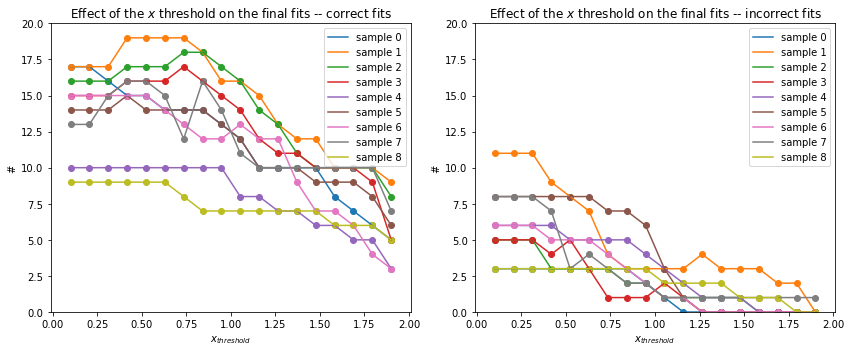

In [299]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for x_threshold_analysis_list, counter_1 in zip(all_threshold_analysis,range(len(all_threshold_analysis))):
    x_threshold_analysis=np.array(x_threshold_analysis_list)
    plt.scatter(x_threshold_analysis[:,0],x_threshold_analysis[:,1])
    plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,1],label='sample '+str(counter_1))
    #plt.scatter(x_threshold_analysis[:,0],x_threshold_analysis[:,2])
    #plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,2],label='incorrect')
    #plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,2]/x_threshold_analysis[:,1],label='incorrect')
    plt.xlabel('$x_{threshold}$')
    plt.ylabel('#')
    plt.title('Effect of the $x$ threshold on the final fits -- correct fits')
plt.ylim(0,20)
plt.legend()
plt.subplot(1,2,2)
for x_threshold_analysis_list, counter_1 in zip(all_threshold_analysis,range(len(all_threshold_analysis))):
    x_threshold_analysis=np.array(x_threshold_analysis_list)
    #plt.scatter(x_threshold_analysis[:,0],x_threshold_analysis[:,1])
    #plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,1],label='sample '+str(counter_1))
    plt.scatter(x_threshold_analysis[:,0],x_threshold_analysis[:,2])
    plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,2],label='sample '+str(counter_1))
    #plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,2]/x_threshold_analysis[:,1],label='incorrect')
    plt.xlabel('$x_{threshold}$')
    plt.ylabel('#')
    plt.title('Effect of the $x$ threshold on the final fits -- incorrect fits')
plt.ylim(0,20)
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir+'x_threshold_analysis.pdf')
plt.show()

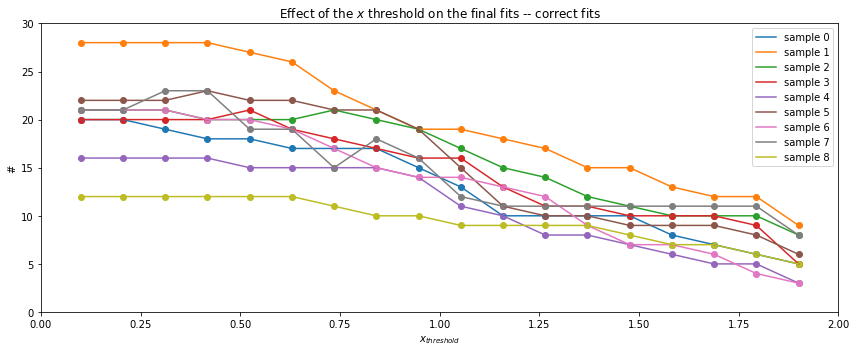

In [305]:
plt.figure(figsize=(12,5))
#plt.subplot(1,2,1)
for x_threshold_analysis_list, counter_1 in zip(all_threshold_analysis,range(len(all_threshold_analysis))):
    x_threshold_analysis=np.array(x_threshold_analysis_list)
    plt.scatter(x_threshold_analysis[:,0],x_threshold_analysis[:,1]+x_threshold_analysis[:,2])
    plt.plot(x_threshold_analysis[:,0],x_threshold_analysis[:,1]+x_threshold_analysis[:,2],label='sample '+str(counter_1))
    plt.xlabel('$x_{threshold}$')
    plt.ylabel('#')
    plt.title('Effect of the $x$ threshold on the final fits -- total final fits')
plt.ylim(0,30)
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir+'x_threshold_analysis_2.pdf')
plt.show()

Why can increasing the threshold, which reduces the amount of fits, increase the amount of correct fits?

## Other stuff

/Users/juan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log


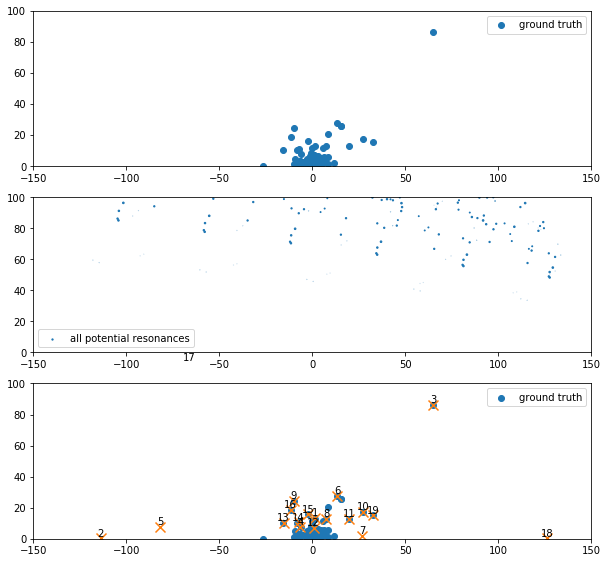

In [137]:
plt.figure(figsize=(10,20))
# plot the ground truth values
plt.subplot(6,1,1)
plt.scatter(prime_sample['A']/analysis.mag,np.abs(prime_sample['B'])/analysis.mag, label='ground truth')
plt.xlim(-150,150)
plt.ylim(0,100)
plt.legend()
plt.subplot(6,1,2)
# plot stage 1 fit values
plt.scatter(A1/analysis.mag,
            B1/analysis.mag,
            label='all potential resonances',
            s=np.log(1./E1))
plt.xlim(-150,150)
plt.ylim(0,100)
plt.legend()
plt.subplot(6,1,3)
# plot the final fit values
plt.scatter(prime_sample['A']/analysis.mag,np.abs(prime_sample['B'])/analysis.mag, label='ground truth')

plt.scatter(As/analysis.mag,Bs/analysis.mag,marker='x',s=100)
# and also number them
for this_A, this_B, counter in zip(As,Bs,range(len(As))):
    plt.text(this_A/analysis.mag, 
             this_B/analysis.mag, 
             str(counter+1),
             ha='center',
             va='bottom')
#plt.xlim(-10,10)
#plt.ylim(0,20)
plt.margins(0.1)
plt.xlim(-150,150)
plt.ylim(0,100)
plt.legend()
plt.show()

## Trashcan

In [ ]:
# %load analysis.py
# NV-spin-tomography Michael Scheer mgscheer@gmail.com

# the main code for the analysis

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize as opt
from scipy import special, fftpack, signal
import operator, heapq, itertools, warnings
import sklearn as sk
import learning

# frequency scale -- turns kHz into radial Hz. Used for printing paramaters nicely
mag = 2 * np.pi * 1e3

# a special error class that is thrown in this code when a fit does not work
class FitError(Exception):
	def __init__(self, value):
		self.value = value
	def __str__(self):
		return repr(self.value)

# create a nice looking plot
def initialize_data_plot(figsize = (10,5), xlims = None, ylims = [-1.05,1.05]):
	fig,ax = plt.subplots(figsize=figsize)
	ax.set_ylim(ylims)
	if xlims is not None:
		ax.set_xlim(xlims)
	return fig, ax

# calculates the M function for a single spin A, B
def calc_M_single(A,B,N,omega_larmor,tau):
	tau = np.array(tau)
	omega_tilde = np.sqrt((A + omega_larmor) ** 2 + B ** 2)
	mx = B/omega_tilde
	mz = (A+omega_larmor)/omega_tilde
	alpha = omega_tilde * tau
	beta = omega_larmor * tau
	cos_phi = np.cos(alpha) * np.cos(beta)- mz * np.sin(alpha) * np.sin(beta)
	vec_num = (mx ** 2) * (1-np.cos(alpha)) * (1-np.cos(beta))
	vec_denom = 1.0 + cos_phi
	for i in np.where(vec_denom == 0.0)[0]:
		vec_denom[i] = .0001
	vec_term = vec_num/vec_denom
	angle_term = np.sin(N * np.arccos(cos_phi) / 2.0) ** 2
	return 1 - (vec_term * angle_term)

# calculates the M function corresponding to many spins given by
# A_list, B_list
# equivalent to np.array([calc_M_single(A, B, N, omega_larmor, tau) for A, B in zip(A_list, B_list)]).prod()
def calc_M(A_list, B_list, N, omega_larmor, tau):
	'''
	calc_M(A_list, B_list, N, omega_larmor, tau)
	gives back M
	'''
	return reduce(lambda accum, next: accum * calc_M_single(next[0], next[1], N, omega_larmor, tau), zip(A_list, B_list), 1.0)

# calculates what A and B must be given the value of cos(phi) as well as omega_tilde
def calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde):
	alpha = omega_tilde * res_tau
	beta = omega_larmor * res_tau
	mz = (np.cos(alpha) * np.cos(beta) - cosphi)/(np.sin(alpha) * np.sin(beta))
	A = mz * omega_tilde - omega_larmor
	B = np.sqrt((1 - mz ** 2)) * omega_tilde
	return A, np.abs(B)

# Firm bounds on omega_tilde arising from an upper bound on hyperfine couplings
def omega_bounds(omega_larmor, coupling_bound = 150 * mag):
	upper_omega_bound = omega_larmor + coupling_bound
	lower_omega_bound = omega_larmor - coupling_bound
	return lower_omega_bound, upper_omega_bound

# checks if the A, B pair has a coupling larger than coupling_bound
def valid_A_B(A, B, coupling_bound = 150 * mag):
	return A ** 2 + B ** 2 <= coupling_bound ** 2

# for a real sequence y indexed by a sequence x,
# writes y = a0 + a1 * cos(omega_0 * x) + b1 * sin(omega_0 * x) + ...
# with omega_0 = 2 * np.pi/len(x)
# as a "fourier series" (though for discrete y not continuous) and finds (very approximately)
# the a and b coefficients.
# coefs.real = a0, a1, a2, ...
# coefs.imag = 0, -b1, -b2, ... (notice the negative signs)
# see http://www.feynmanlectures.caltech.edu/I_50.html for fourier series and
# http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.fftpack.fft.html for the formula used for FFT.
# notice the 2/N difference between the two formulas for all but the 0 frequency term.
def sinusoid_coefs_fft(x, y):
	ft = fftpack.fft(y)
	freqs = fftpack.fftfreq(len(x), d = (x[1]-x[0])/(2*np.pi))
	# get rid of negative frequencies
	ft, freqs = map(np.array, zip(*filter(lambda p: p[1] >= 0, zip(ft, freqs))))
	coefs = 2.0 * np.array(ft)/len(x)
	coefs[0] = .5 * coefs[0]
	return coefs, freqs

# given the coefs and freqs from sinusoid_coefs_fft, finds the most likely frequencies
# present in the signal. It looks for peaks in both the real and imaginary part of the coefficients.
# it returns a list of frequencies in decreasing order of likelihood, based on the absolute value of the
# fourier spectrum (coefs) at that point.
def find_peaks_from_fourier(coefs, freqs):
	extremal_inds = signal.argrelextrema(coefs.real, np.greater)[0]
	extremal_inds = np.r_[extremal_inds, signal.argrelextrema(coefs.real, np.less)[0]]
	extremal_inds = np.r_[extremal_inds, signal.argrelextrema(coefs.imag, np.greater)[0]]
	extremal_inds = np.r_[extremal_inds, signal.argrelextrema(coefs.imag, np.less)[0]]
	extremal_inds = np.unique(extremal_inds)
	freq_inds = sorted(extremal_inds, key=lambda ind: -np.abs(coefs[ind]))
	return freqs[freq_inds]

# takes a list of frequencies that are peaks in a fourier spectrum, either of the real
# or imaginary part as well as a number of spins to look for. It then approximates the frequencies
# of the underlying product cosine functions that were in the signal. See appendix C of thesis.
def gen_freqs_from_fourier(freqs, num_spins):
	# sort them in decreasing order
	freqs = sorted(freqs, key=lambda x:-x)
	if num_spins == 1: # requires 1 freq
		return [freqs[0]]
	elif num_spins == 2: # requires 2 freqs
		f0, f1 = freqs[:2]
		return [.5 * (f0 + f1), .5 * (f0 - f1)]
	elif num_spins == 3: # requires 3 freqs
		f0, f1, f2 = freqs[:3]
		return [.5 * (f1 + f2), .5 * (f0 - f2), .5 * (f0 - f1)]
	elif num_spins == 4: # requires 5 freqs
		phi01sum, phi2, phi3 = gen_freqs_from_fourier(freqs[:4], 3)
		f3, f4 = freqs[3:5]        
		phi0 = .5 * (f3 + f4)
		phi1 = phi01sum - phi0
		return [phi0, phi1, phi2, phi3]
	else:
		return gen_freqs_from_fourier(freqs, 4) # change this if you figure out how to do 5

# the form of the signal as a function of N for a fixed tau
def spin_fit_fun_single(N, phi, x):
	return 1 - x * (np.sin(N * phi/2.0) ** 2)

# the form of the signal as a function of N for a fixed tau with several spins
# there can be any number of spins passed, in the form [phi0, phi1, ..., phin, x0, x1, ..., xn]
# where the function for a single spin is 1 - x * (np.sin(N * phi/2.0) ** 2)
# equivalent to np.array([single_spin_fit_fun(N, phi, x) for phi, x in zip(phis, xs)]).prod()
def spin_fit_fun(N, *args):
	num_spins = len(args)/2
	phis, xs = args[:num_spins], args[num_spins:2*num_spins]
	return reduce(lambda accum, next: accum * spin_fit_fun_single(N, next[0], next[1]), zip(phis, xs), 1.0)

# for two arrays l1 and l2 returns the squared error between them
def squared_error(l1, l2):
	return sum((l1 - l2) ** 2)

# Use scipy.optimize.curve_fit to fit N_data to several spins using fit_fun. Requires a guess of the spin
# parameters (phi's and x's) as param_guess
def spin_fit_guess(N_vals, N_data, num_spins, param_guess, error_fun = squared_error, fit_fun = spin_fit_fun):
	try:
		with warnings.catch_warnings():
			warnings.simplefilter("ignore")
			popts, pcovs = opt.curve_fit(fit_fun, N_vals, N_data, p0 = param_guess)
		xs = popts[num_spins:2*num_spins]
		error = error_fun(fit_fun(N_vals, *popts), N_data)
		return popts, error, np.all((xs > 0) & (xs <= 2))
	except (RuntimeError, TypeError):
		raise FitError("Failed to fit spins with N data.")

# fit possibly several spins using a fit_fun to N_data
# for reference, see http://stackoverflow.com/questions/13405053/scipy-leastsq-fit-to-a-sine-wave-failing
# and appendix C of thesis.
def spin_fit(N_vals, N_data, error_fun = squared_error, verbose = True, plots = True, fit_fun = spin_fit_fun, extra_params = []):
	coefs, freqs = sinusoid_coefs_fft(N_vals, N_data)
	likely_freqs = find_peaks_from_fourier(coefs, freqs)
	params, errors, spins_found = [], [], []
	# the higest number of spins that can be fit with l frequencies
	def highest_spin(l):
		if l <= 3:
			return l
		elif l == 4:
			return 3
		else:
			return 4 # make this 5 if you figure out how to do 5
	for num_spins in range(1,1 + highest_spin(len(likely_freqs))):
		approx_phis = gen_freqs_from_fourier(likely_freqs, num_spins)
		approx_xs = num_spins * [2.0]
		p0s = approx_phis + approx_xs + extra_params[:num_spins]
		try:
			popts, error, valid = spin_fit_guess(N_vals, N_data, num_spins, p0s, error_fun = error_fun, fit_fun = fit_fun)
			if valid:
				params.append(popts)
				errors.append(error)
				spins_found.append(num_spins)
		except FitError:
			pass
	if not params:
		raise FitError("Failed to fit spins with N data.")
	else:
		ind = np.argmin(errors)
		if plots:
			plt.figure(figsize=(10,10))
			plt.plot(freqs, coefs.real, label = 'real part')
			plt.plot(freqs, coefs.imag, label = 'imag part')
			plt.title('Fourier spectrum')
			plt.xlabel('phi')
			plt.ylabel('Fourier coeficient')
			plt.legend()
			plt.show()
			plt.figure(figsize=(10,10))
			plt.plot(N_vals, N_data, '.-k', lw=0.4, label = 'data')
			plt.plot(N_vals, fit_fun(N_vals, *params[ind]), label = 'fit')
			plt.title('Fitted N data')
			plt.xlabel('N')
			plt.ylabel('M')
			plt.legend()
			plt.show()
		return params[ind], spins_found[ind]

# repeated attempts to fit N_vals and N_data using several spins. It tries subsets of the data of increasing length
# and then uses the best result as a guess for one final fit of the whole data. See appendix C of thesis for more detail.
def repeated_spin_fit(N_vals, N_data, error_tol, error_fun = squared_error, num_subsets = 4,
	fit_fun = spin_fit_fun, extra_params = [], verbose = True, plots = True):
	spin_fits, scaled_errors = [], []
	for subset in [np.arange(int(len(N_vals) * r)) for r in np.linspace(0, 1, 1 + num_subsets)[1:]]:
		try:
			spin_ans = spin_fit(N_vals[subset], N_data[subset], error_fun = error_fun, fit_fun = fit_fun,
				extra_params = extra_params, verbose = verbose, plots = plots)
			spin_fits.append(spin_ans)
			scaled_errors.append(1.0 * error_fun(fit_fun(N_vals, *spin_ans[0]), N_data)/len(N_vals))
		except FitError:
			pass
	if not spin_fits:
		raise FitError("Failed to fit spins with N data.")
	min_ind = np.argmin(scaled_errors)
	popt_spin, num_spins = spin_fits[min_ind]
	if verbose:
		print "best before final pass: ", min_ind
		phis, xs = np.array(popt_spin[:num_spins]) % np.pi, np.array(popt_spin[num_spins:2*num_spins])
		phis, xs = map(np.array, zip(*sorted(zip(phis, xs), key = lambda x:-x[1])))# sort phis in decreasing order by xs
		print "answer before final pass: ", xs, phis
	try:
		popts, error, valid = spin_fit_guess(N_vals, N_data, num_spins, popt_spin, error_fun = error_fun, fit_fun = fit_fun)
		if valid:
			spin_fits.append((popts, num_spins))
			scaled_errors.append(1.0 * error_fun(fit_fun(N_vals, *popts), N_data)/len(N_vals))
			min_ind = np.argmin(scaled_errors)
			popt_spin, num_spins = spin_fits[min_ind]
		if plots:
			plt.figure(figsize = (10,10))
			plt.plot(N_vals, N_data, '.-k', lw=0.4, label = 'data')
			plt.plot(N_vals, fit_fun(N_vals, *popts), label = 'fit')
			plt.title('Fitted N data')
			plt.xlabel('N')
			plt.ylabel('M')
			plt.legend()
			plt.show()
	except FitError:
		pass
	if verbose:
		print "best overall: ", min_ind
		print scaled_errors
	scaled_error = scaled_errors[min_ind]
	phis, xs = np.array(popt_spin[:num_spins]) % np.pi, np.array(popt_spin[num_spins:2*num_spins])
	#phis, xs = map(np.array, zip(*sorted(zip(phis, xs), key = lambda x:-x[1])))# sort phis in decreasing order by xs
	return phis, xs, scaled_error    

# creates a tau vector that matches the tau from real data from Tim and Julia.
# should be filled in with realistic tau vectors for other N in the future.
def choose_tau_params(N, num_samples = 5100):
	if N != 64:
		raise FitError("N should be 64")
	else:
		min_tau = 3.0000000000000001e-06
		max_tau = 2.1999999999999999e-05
		length = num_samples
		tau = np.linspace(min_tau, max_tau, length)
		return tau

# finds local minima in the vector data as well as the intervals in which they are minima.
# only finds dips below fit_dips_below and less wide than max_width if the parameters are not None.
def find_resonances(data, fit_dips_below = None, max_width = None):
	min_inds = (signal.argrelextrema(data, np.less)[0]).astype(int)
	max_inds = (signal.argrelextrema(data, np.greater)[0]).astype(int)
	widths = max_inds[1:] - max_inds[:-1]
	dip_inds = min_inds[1:] if min_inds[0] < max_inds[0] else min_inds[:-1]
	windows = [(max_inds[i], max_inds[i+1]) for i in range(len(dip_inds)-1)] # should this be 3?
	# a dip must go below fit_dips_below, unless fit_dips_below = None and it's width should be at most max_width unless max_width = None
	filter_fun = lambda p: ((data[p[0]] < fit_dips_below) if (fit_dips_below != None) else True) and (p[1] <= max_width if max_width != None else True)
	dip_inds, widths, windows = map(np.array, zip(*filter(filter_fun, zip(dip_inds, widths, windows))))
	# sort by width
	# sort_inds = np.argsort(-1 * widths)
	# return dip_inds[sort_inds], windows[sort_inds]
	return dip_inds, windows

# Calculates all possible omega_tilde values for a given phi and x at a given res_tau.
# See chapter 4 of thesis.
def calc_omega_tilde(phi, x, res_tau, omega_larmor):
	beta = omega_larmor * res_tau
	cosbeta, cosphi_0 = np.cos(beta), np.cos(phi)
	lower_omega_bound, upper_omega_bound = omega_bounds(omega_larmor)
	omega_cosphi = []
	for cosphi in [cosphi_0, -cosphi_0]:
		prod = x * (1+cosbeta) * (1+cosphi)
		coeff = [1, prod - 2 * cosbeta * cosphi, prod + cosbeta ** 2 + cosphi ** 2 - 1]
		if coeff[1] ** 2 - 4 * coeff[0] * coeff[2] >= 0: # discriminant is nonnegative
			cosalphas = np.roots(coeff)
			for cosalpha in filter(lambda x: np.abs(x) <= 1, cosalphas):
				alpha_0_pi = np.arccos(cosalpha)
				for alpha_base in [alpha_0_pi, 2 * np.pi - alpha_0_pi]:
					lower_int = int(np.ceil((lower_omega_bound * res_tau - alpha_base)/(2 * np.pi)))
					upper_int = int(np.floor((upper_omega_bound * res_tau - alpha_base)/(2 * np.pi)))
					for n in range(lower_int, upper_int + 1):
						omega_cosphi.append(((alpha_base + 2 * np.pi * n)/res_tau, cosphi))
	return omega_cosphi

# for a given dip_ind, measures N data and fits it using repeated_spin_fit. If the fit error is less than error_tol,
# it finds all possible A and B values for each fit spin. Each possible A and B value that is within the bounds (is_valid)
# is added to spin_dict.
def analyze_dip(dip_ind, tau, data_func, omega_larmor, spin_dict = {}, error_tol = .1/64,
				N_vals = np.arange(0,256,2), error_fun = squared_error, fit_fun = spin_fit_fun, extra_params = [],
				num_subsets = 4, verbose = False, plots = False):
	res_tau = tau[dip_ind]
	N_data = data_func(N_vals, res_tau)
	try:
		phis, xs, scaled_error = repeated_spin_fit(N_vals, N_data, error_fun = error_fun, fit_fun = fit_fun, extra_params = extra_params,
			num_subsets = num_subsets, verbose = verbose, plots = plots)
	except FitError:
		if verbose:
			print "Failed to fit spins with N data."
		return spin_dict
	if verbose:
		print "res_tau: ", res_tau
		print "scaled_error <= error_tol: ", scaled_error <= error_tol
		print "scaled_error: ", scaled_error
		phis, xs = map(np.array, zip(*sorted(zip(phis, xs), key = lambda x:-x[1])))# sort phis in decreasing order by xs
		print "xs, phis, scaled_error: ", xs, phis, scaled_error
	if scaled_error > error_tol:
		return spin_dict
	for phi, x in zip(phis, xs):
		for omega_tilde, cosphi in calc_omega_tilde(phi, x, res_tau, omega_larmor): # all the possible omegas with their associated cosphis
			A, B = calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
			if valid_A_B(A, B):
				if (dip_ind, phi, x) in spin_dict:
					spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
				else:
					spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
	return spin_dict

# takes in a dict of the type returned by analyze_dip and for each entry which represents a particular spin found at a particular dip
# it chooses the A, B value that minimizes the error_fun from the tau data. It returns these A and B guesses along with the calculated errors.
def choose_spin_guesses(spin_dict, N, omega_larmor, tau, data, classifier, x_min = 1, error_fun = squared_error):
	guess_As, guess_Bs, dataerrs = [], [], []
	all_guess_As, all_guess_Bs, select_As, select_Bs = [], [], [], []
	for k in spin_dict.keys():
		err = []
		for A, B, _ in spin_dict[k]:
			all_guess_As.append(A)
			all_guess_Bs.append(B)
			err.append(error_fun(calc_M_single(A, B, N, omega_larmor, tau), data))
		min_err_ind = np.argmin(err)
		best_A, best_B, best_cosphi = spin_dict[k][min_err_ind]
		select_As.append(best_A)
		select_Bs.append(best_B)
		best_err = err[min_err_ind]
		_, _, x = k
		features = [best_cosphi, x, best_A, best_B, best_err]
		if classifier(features) and x >= x_min:
			guess_As.append(best_A)
			guess_Bs.append(best_B)
			dataerrs.append(best_err)
	return (np.array(guess_As), np.array(guess_Bs), np.array(dataerrs),
		np.array(all_guess_As), np.array(all_guess_Bs), np.array(select_As), np.array(select_Bs))

# given guesses for As and Bs, clusters these guesses using the DBSCAN algorithm.
# for info about DBSCAN see http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# for info about clustering with sklearn see http://scikit-learn.org/stable/modules/clustering.html#clustering
def cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1):
	X = sk.preprocessing.StandardScaler().fit_transform(zip(guess_As, guess_Bs)) # possibly need to be lists?
	db = sk.cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(X)
	labels = db.labels_
	cluster_As, cluster_Bs, cluster_dataerrs = [], [], []
	for k in np.unique(labels):
		if k >= 0:
			label_inds = np.where(labels == k)[0]
			best_guess = np.argmin(dataerrs[label_inds])
			cluster_As.append(guess_As[label_inds][best_guess])
			cluster_Bs.append(guess_Bs[label_inds][best_guess])
			cluster_dataerrs.append(dataerrs[label_inds][best_guess])
	return np.array(cluster_As), np.array(cluster_Bs), np.array(cluster_dataerrs)

# an approximation of the background due to the weakly coupled spins
#A_background = 4 * mag * (np.random.rand(400) - .5)
#B_background = 2 * mag * (np.random.rand(400))
#background_dict = {"A_background" : A_background, "B_background" : B_background}
#learning.store_obj(background_dict, "background_A_B")
background_dict = learning.load_obj("background_A_B")
A_background, B_background = background_dict["A_background"], background_dict["B_background"]

# given guess_As and guess_Bs, this function considers all ways of removing num_remove spins from the guess list
# it compares all of these possibilities along with not taking anything out in terms of the error from this subset to the data
# the error function considers the spins along with 400 weakly coupled spins which approximates the background.
# it returns the optimal subset as well as a number to remove next time: the same number if a spin was removed, otherwise the number
# considered for removal this time plus one (considering taking several out at the same time)
def remove_spins(guess_As, guess_Bs, N, omega_larmor, tau, data, num_remove = 1, error_fun = squared_error, verbose = False):
	# creates all subsets of s with size between lower and upper
	def subset_size_range(s, lower, upper):
		ans = []
		for i in range(lower, upper+1):
			for j in itertools.combinations(s, i):
				ans.append(j)
		return ans
	guess_As, guess_Bs = np.array(guess_As), np.array(guess_Bs)
	M_background = calc_M(A_background, B_background, N, omega_larmor, tau)
	err, As, Bs = [], [], []
	for subset in subset_size_range(range(len(guess_As)), len(guess_As) - num_remove, len(guess_As) - 1):
		subset = np.array(subset)
		err.append(error_fun(M_background * calc_M(guess_As[subset], guess_Bs[subset], N, omega_larmor, tau), data))
		As.append(guess_As[subset])
		Bs.append(guess_Bs[subset])
	best_ind = np.argmin(err)
	orig_error = error_fun(M_background * calc_M(guess_As, guess_Bs, N, omega_larmor, tau), data)
	if verbose:
		print "new error, old error: ", err[best_ind], orig_error
	if orig_error > err[best_ind]:
		return As[best_ind], Bs[best_ind], num_remove
	else:
		return guess_As, guess_Bs, num_remove + 1

# given a data function data_func(N, tau) that represents a diamond, returns an estimation
# of the hyperfine couplings of many c13s. The function returns, in order
# the final estimation, the total set of estimated parameters, the set remaining after using least squares,
# the set remaining after applying the classifier, and then the set after applying clustering. See chapter 4 of thesis.
def analyze_diamond(data_func, N, omega_larmor, kernel = "rbf", verbose = False, plots = False):
	tau = choose_tau_params(N)
	data = data_func(N, tau)
	dip_inds, windows = find_resonances(data, fit_dips_below = None)
	lower_ind_cutoff = 3220 # corresponds to 15 microseconds
	if verbose:
		print "number of dips to measure: ", sum(dip_inds >= lower_ind_cutoff)
	spin_dict = {}
	for dip_ind in dip_inds:
		if dip_ind >= lower_ind_cutoff: # 15 microseconds and on
			spin_dict = analyze_dip(dip_ind, tau, data_func, omega_larmor, spin_dict, N_vals = np.arange(0,256,2),
				error_tol = .1/64, verbose = verbose, plots = plots)
	# load the classifiers
	guess_scaler = learning.load_obj("classifiers/scaler_svm_" + kernel + "_di3220_29diamonds_cxABe")
	guess_clf = learning.load_obj("classifiers/clf_svm_" + kernel + "_di3220_29diamonds_cxABe")
	def guess_classifier(features):
		return guess_clf.predict(guess_scaler.transform([features]))
	guess_As, guess_Bs, dataerrs, all_guess_As, all_guess_Bs, select_As, select_Bs = choose_spin_guesses(spin_dict, N, omega_larmor, tau, data, guess_classifier, x_min = 1, error_fun = squared_error)
	cluster_As, cluster_Bs, cluster_dataerrs = cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
	As, Bs, num_remove = cluster_As, cluster_Bs, 1
	while num_remove <= 2:
		As, Bs, num_remove = remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = squared_error, verbose=verbose)
	return As, Bs, all_guess_As, all_guess_Bs, select_As, select_Bs, guess_As, guess_Bs, cluster_As, cluster_Bs

In [ ]:
# %load learning.py
# NV-spin-tomography Michael Scheer mgscheer@gmail.com

# Creating datasets and training classifiers, storing objects on disk

import numpy as np
import sklearn as sk
from sklearn import svm, preprocessing, cross_validation, cluster, metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib
import analysis
import NV_generator
import pickle

# store an object in a file
def store_obj(obj, fname):
	joblib.dump(obj, fname + ".pkl")

def store_obj_2(obj, fname):
	pickle.dump(obj, open(fname + ".pkl",'wb'))

# load an object from a file
def load_obj(fname):
	return joblib.load(fname + ".pkl")

def load_obj_2(fname):
	return pickle.load(open(fname + ".pkl",'rb'))

# decides if a fitted A and B are close enough to a spin to be counted as a fit.
# the B tends to be harder to fit so the accuracy demanded is less.
def is_fit(fitted_A, fitted_B, spin, A_acc = .1, B_acc = .5):
	A_acc = analysis.mag * A_acc
	B_acc= analysis.mag * B_acc
	return ((spin[0] >= fitted_A - A_acc) and (spin[0] <= fitted_A + A_acc) and
		(spin[1] >= fitted_B - B_acc) and (spin[1] <= fitted_B + B_acc))

# creates a dataset of diamonds with N measurements already analyzed, saves it to disk
def create_diamonds(diamond_num_list, omega_larmor, num_spins = 450):
	verbose, plots = False, False
	num_subsets = 4
	error_fun = analysis.squared_error
	error_tol = .1/64
	N = 64
	N_vals = np.arange(0, 256, 2)
	tau = analysis.choose_tau_params(N)
	for diamond_num in diamond_num_list:
		print "diamond_num: ", diamond_num
		A, B, r, costheta, sintheta = NV_generator.generate_spins(num_spins)
		def data_func(N, tau, noise_level = .02):
			data = analysis.calc_M(A, B, N, omega_larmor, tau)
			noise = np.random.randn(len(data)) * noise_level
			return data + noise
		data = data_func(N, tau)
		dip_inds, windows = analysis.find_resonances(data, fit_dips_below = None)
		successful_fits, good_fits, phis_list, xs_list, scaled_errors = [], [], [], [], []
		print "number of dips: ", len(dip_inds)
		for dii in range(len(dip_inds)):
			if dii%50==0:
				print "dii: ", dii
			dip_ind = dip_inds[dii]
			res_tau = tau[dip_ind]
			N_data = data_func(N_vals, res_tau)
			successful_fit, good_fit = True, True # did the fit succeed without throwing an error? was the error in the fit small enough?
			try:
				phis, xs, scaled_error = analysis.repeated_spin_fit(N_vals, N_data, error_tol = error_tol, error_fun = error_fun, num_subsets = num_subsets, verbose = verbose, plots = plots)
				good_fit = scaled_error <= error_tol
			except analysis.FitError:
				successful_fit, good_fit = False, False
				phis, xs = None, None
				scaled_error = None
			successful_fits.append(successful_fit)
			good_fits.append(good_fit)
			phis_list.append(phis)
			xs_list.append(xs)
			scaled_errors.append(scaled_errors)
		print "create diamond_dict"
		diamond_dict = {"A" : A, "B" : B, "r" : r, "costheta" : costheta, "sintheta" : sintheta, "N" : N,
			"tau" : tau, "data" : data, "N_vals" : N_vals, "N_data" : N_data, "dip_inds" : dip_inds, "windows" : windows,
			"successful_fits" : successful_fits, "good_fits" : good_fits, "error_tol" : error_tol, "num_subsets" : num_subsets,
			"phis_list" : phis_list, "xs_list" : xs_list, "scaled_errors" : scaled_errors}
		print "store diamond_dict"
		store_obj_2(diamond_dict, "diamonds/diamond_" + str(diamond_num))

# train and optionally save a support vector machine classifier
# scaler preprocesses the data (scales it) and clf is the classifier
def train_svm(train_X, train_Y, test_X, test_Y, kernel = 'rbf', C=1.0, verbose = False, pickle = False, suffix = ""):
	scaler = sk.preprocessing.StandardScaler().fit(train_X)
	clf = sk.svm.SVC(kernel = kernel, C=C)# svm with rbf kernel (default)
	clf.fit(scaler.transform(train_X), train_Y)
	if verbose:
		print "training score: ", clf.score(scaler.transform(train_X), train_Y)
		print "testing score: ", clf.score(scaler.transform(test_X), test_Y)
	if pickle:
		store_obj(scaler, "classifiers/scaler_svm_" + kernel + suffix)
		store_obj(clf, "classifiers/clf_svm_" + kernel + suffix)
	return scaler, clf

# train and optionally save an extra-trees classifier
# scaler preprocesses the data (scales it) and clf is the classifier
def train_trees(train_X, train_Y, test_X, test_Y, verbose = False, pickle = False, suffix = ""):
	scaler = sk.preprocessing.StandardScaler().fit(train_X)
	clf = sk.ensemble.ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=1, random_state=0)
	clf.fit(scaler.transform(train_X), train_Y)
	if verbose:
		print "training score: ", clf.score(scaler.transform(train_X), train_Y)
		print "testing score: ", clf.score(scaler.transform(test_X), test_Y)
	if pickle:
		store_obj(scaler, "classifiers/scaler_trees" + suffix)
		store_obj(clf, "classifiers/clf_trees" + suffix)
	return scaler, clf

# creates and optionally saves the dataset used to train the SVM which classifies guesses.
def guess_dataset(diamonds, omega_larmor, min_dip_ind = 3220, training_percent = .75, pickle = False, suffix = ""):
	train_X = [] # feature vectors
	train_Y = [] # classifications
	test_X = []
	test_Y = []
	error_fun = analysis.squared_error
	for diamond_ind in range(len(diamonds)):
		print "diamond_ind: ", diamond_ind
		diamond = diamonds[diamond_ind]
		tau = diamond["tau"]
		data = diamond["data"]
		N = diamond["N"]
		dip_inds = diamond["dip_inds"] # the indices for the dips
		windows = diamond["windows"] # where was this used?
		spin_dict = {} # The keys to the dictionary will be a tuple (dip_ind, phi, x)
		for dii in range(len(dip_inds)):
			if diamond["good_fits"][dii] and dip_inds[dii] >= min_dip_ind:
				dip_ind = dip_inds[dii]
				res_tau = tau[dip_ind]
				for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
					for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
						A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
						if analysis.valid_A_B(A, B): # this checks for the upper bound imposed on (A,B)
							if (dip_ind, phi, x) in spin_dict: # if (dip_ind,phi,x) is already a key in the dictionary then add another value to the list that corresponds to it
								spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
							else: # if it is not, then simply initialize the list with the corresponding tuple
								spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
		for k in spin_dict.keys(): #now iterate through they dictionary's keys
			err = []
			for A, B, _ in spin_dict[k]:
				err.append(error_fun(analysis.calc_M_single(A, B, N, omega_larmor, tau), data)) # calculate the errors from assuming data only comes from a single spin
			min_err_ind = np.argmin(err)
			best_A, best_B, best_cosphi = spin_dict[k][min_err_ind]
			best_err = err[min_err_ind]
			_, _, x = k 
			features = [best_cosphi, x, best_A, best_B, best_err] # this is the feature vector
			tag = 0
			for spin in set(zip(diamond["A"], np.abs(diamond["B"]))): #iterate through the true spins in the diamond
				if is_fit(best_A, best_B, spin, A_acc = .5, B_acc = 2): # arbitrary thresholds over here
					tag = 1 # best_A and best_B have been found to correspond to a one of the true spins
					break
			if diamond_ind < training_percent * len(diamonds): # first diamonds for the training set
				train_X.append(features)
				train_Y.append(tag)
			else: # the other ones for the test set
				test_X.append(features)
				test_Y.append(tag)
	if pickle:
		print "create dataset"
		dataset = {"train_X" : train_X, "train_Y" : train_Y, "test_X" : test_X, "test_Y" : test_Y}
		print "store dataset"
		store_obj(dataset, "datasets/guess_dataset" + suffix)
	return train_X, train_Y, test_X, test_Y


In [ ]:
# %load NV_generator.py
# NV-spin-tomography Michael Scheer mgscheer@gmail.com

# generating random NV centers

import numpy as np
import itertools

# For explanation of the formulas used here, see chapter 2 of thesis.

# Constants
# lattice constant of diamond
a0 = 3.567 * 10 ** (-10) # in meters
# Hyperfine coupling related constants
gam_el = -1.760859 * 10 ** 11 # Gyromagnetic ratio for a single electron in rad s-1 T-1
gam_n = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
hbar = 1.05457173 * 10 ** (-34)
pi = np.pi
h = hbar * 2 * pi
mu0 = 4 * pi * 10 ** (-7)

# Carbon Lattice Definition
# Basis vectors
# i, j, k are basis vectors of Face Centered Cubic Bravais lattice
i = a0/2*np.array([0,1,1])
j = a0/2*np.array([1,0,1])
k = a0/2*np.array([1,1,0])
# a and b are the relative positions of the nitrogen and vacancy
a = np.array([0,0,0])
b = a0/4*np.array([1,1,1])
# rotate all the vectors so that the symmetry axis (b) of the NV center is along the z direction
# rotation around z axis by pi/4 puts b in yz plane
Rz = np.array([[np.cos(pi/4),-np.sin(pi/4),0],[np.sin(pi/4),np.cos(pi/4),0],[0,0,1]])
sqrt2angle = np.arctan(np.sqrt(2))
# rotation around x axis by sqrt2angle moves b from yz plane to z axis
Rx = np.array([[1,0,0],[0,np.cos(sqrt2angle),-np.sin(sqrt2angle)],[0,np.sin(sqrt2angle),np.cos(sqrt2angle)]])
b = Rx.dot(Rz).dot(b)
i = Rx.dot(Rz).dot(i)
j = Rx.dot(Rz).dot(j)
k = Rx.dot(Rz).dot(k)

hyperfine_prefactor = -1 * mu0 * gam_el * gam_n * hbar/(4 * pi) # Only one hbar instead of hbar ** 2 since we convert to angular frequency units in the hamiltonian.

# Takes Carbon Concentration, and gridsize (N) as inputs
# Returns a list of 2D numpy arrays with hyperfine couplings of c13 nuclei to the NV center in angular frequency Hz
# If sphere is true the c13 nuclei inside a sphere are returned instead of those inside a cube.	
def generate_NV(c13_concentration=0.011,N=25,sphere = True):
	# define position of NV in middle of the grid
	center = round(N/2)
	NVPos = center * i + center * j + center * k

	spin_list = []
	#Calculate hyperfine strength for all gridpoints
	for n, m, l in itertools.product(range(N), repeat = 3):
		if (n,m,l) != (center, center, center): # all lattice pairs except the nitrogen and vacancy
			lattice_position = n * i + m * j + l * k - NVPos # relative position of a lattice point to the NV center
			for pos in [lattice_position, lattice_position + b]: # the two lattice positions at this grid location
				x, y, z = pos
				r = np.sqrt(pos.dot(pos))
				costheta = z/r
				sintheta = np.sqrt(x ** 2 + y ** 2)/r
				A = hyperfine_prefactor * (3 * costheta ** 2 - 1)/(r ** 3)
				B = hyperfine_prefactor * 3 * costheta * sintheta /(r ** 3)
				spin_list.append((r, A, B, costheta, sintheta))

	if sphere:
		spin_list.sort() # sort by r value from smallest to largest
		spin_list = spin_list[:len(spin_list)/2] # keep the closest half of the spins

	# for each lattice point, let it be a c13 with probability c13_concentration 
	c13_inds = np.where(np.random.rand(len(spin_list))<c13_concentration)[0]
	c13_spins = np.array(spin_list)[c13_inds]
	r, A, B, costheta, sintheta = zip(*c13_spins)
	return np.array(A), np.array(B), np.array(r), np.array(costheta), np.array(sintheta)

# Generates C13s near a NV center. The number of C13s is roughly num_spins if N==None.
# If enforce_bound = True, the random generation will repeat until there are no couplings greater than coupling_bound.
def generate_spins(num_spins, enforce_bound = True, coupling_bound = 150 * 2 * pi * 1e3, c13_concentration = 0.011, N = None, abs_val = False, verbose = False):
	if N == None:
		N = int(np.ceil(((num_spins*1.0)/c13_concentration) ** (1.0/3)))
	if verbose:
		print "N:", N
	A, B, r, costheta, sintheta = generate_NV(N = N, c13_concentration = c13_concentration)
	while enforce_bound and (np.any(A ** 2 + B ** 2 > (coupling_bound) ** 2)):
		A, B, r, costheta, sintheta = generate_NV(N = N, c13_concentration = c13_concentration)
	if abs_val:
		B = np.abs(B)
	return A, B, r, costheta, sintheta



